# I. Data Collection & Data Preprocessing
## Libraries and package installation

In [ ]:
!pip install pybaseball
!pip install fuzzy-c-means
!pip install scikit-fuzzy
!pip install torch
!pip install torchvision
!pip install baseball-scraper
!pip install sqlite3
!pip install datetime
import pybaseball as pb
import torch
import torch.nn as nn 
import torch.nn. functional as F
import torchvision
import torchvision.transforms as transforms
import skfuzzy as fuzz
import sklearn.metrics as metrics
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import sqlite3
from baseball_scraper import statcast

### Statcast Data

In [ ]:
pd.read_csv(r"/Users/stephenak24/Downloads/exit_velocity.csv")

In [154]:
new_statcast_data = pd.read_csv(r"/Users/stephenak24/Downloads/exit_velocity.csv")

In [ ]:
# Remove the excesss columns
columns_to_keep = ['player_id', 'last_name, first_name','ev50', 'brl_percent', 'ev95percent']
new_statcast_data_cleaned = new_statcast_data[columns_to_keep].copy()

# Renaming some of the columns (for aesthetic purposes)
new_statcast_data_cleaned.rename(columns={
    'ev50': '50th Max Velo', 
    'brl_percent': 'Brls/BBE%',
    'ev95percent': 'Hard Hit%'
}, inplace=True)
new_statcast_data_cleaned

### Using the pybaseball library package to collect Fangraphs 2023 season data

In [ ]:
from pybaseball import batting_stats

hitting_stats_2023 = batting_stats(2023)

# column names to verify them
print(hitting_stats_2023.columns.tolist())

# list of columns to keep
columns_to_keep = [
   'IDfg', 'Season', 'Name', 'Team', 'Age','Swing%','O-Swing%', 'O-Contact%', 'Z-Swing%', 'Z-Contact%','SwStr%', 'Pull%', 'Oppo%', 'FB%', 'LD%', 'GB%', 'K%', 'BB%', 'Spd'
]

hitting_stats_2023_cleaned = hitting_stats_2023[columns_to_keep].copy()
print(hitting_stats_2023_cleaned.head())

In [157]:
print(hitting_stats_2023_cleaned.columns)
print(new_statcast_data_cleaned.columns)

Index(['IDfg', 'Season', 'Name', 'Team', 'Age', 'Swing%', 'O-Swing%',
       'O-Contact%', 'Z-Swing%', 'Z-Contact%', 'SwStr%', 'Pull%', 'Oppo%',
       'FB%', 'LD%', 'GB%', 'K%', 'BB%', 'Spd'],
      dtype='object')
Index(['player_id', 'last_name, first_name', '50th Max Velo', 'Brls/BBE%',
       'Hard Hit%'],
      dtype='object')


Some nasty, annoying data issues I ran into when trying to merge. The Fangraphs player ID from pybaseball does not match Statcast's ID. So you have to merge on the player's name, the big issue was how the names were formatted on the Statcast end. 

An easier work around that I found out much later, was to go to the actual Fangraphs website and get the data from there, through exporting to a csv. Two player IDs are included, Fangraphs own one, and the Statcast one. **I wish I had known this beforehand** :|

In [158]:
# Split the 'last_name, first_name' column into two new columns
new_statcast_data_cleaned[['last_name', 'first_name']] = new_statcast_data_cleaned['last_name, first_name'].str.split(',', expand=True)

In [ ]:
# Splitting the 'last_name, first_name' into two separate columns 'first_name' and 'last_name'
new_statcast_data_cleaned[['last_name', 'first_name']] = new_statcast_data_cleaned['last_name, first_name'].str.split(',', expand=True)

# The expand=True parameter will return a DataFrame with separate columns.
new_statcast_data_cleaned['last_name'] = new_statcast_data_cleaned['last_name'].str.strip()
new_statcast_data_cleaned['first_name'] = new_statcast_data_cleaned['first_name'].str.strip()

new_statcast_data_cleaned[['last_name', 'first_name']]

In [160]:
# Split 'Name' column into two separate columns 'first_name' and 'last_name'
split_names = hitting_stats_2023_cleaned['Name'].str.rsplit(' ', n=1, expand=True)

# Assign the split columns back to the dataframe
hitting_stats_2023_cleaned['first_name'] = split_names[0]
hitting_stats_2023_cleaned['last_name'] = split_names[1]

# drop the original 'Name' column, no longer need it
hitting_stats_2023_cleaned.drop('Name', axis=1, inplace=True)

## Merging the dataframes

In [161]:
merged_df = pd.merge(hitting_stats_2023_cleaned, new_statcast_data_cleaned, 
                     left_on=['first_name', 'last_name'], 
                     right_on=['first_name', 'last_name'], 
                     how='inner')

In [ ]:
# drop excess name columns
merged_df.drop('last_name, first_name', axis=1, inplace=True)
merged_df

In [ ]:
# Changing the column order
new_order = ['IDfg', 'player_id', 'first_name', 'last_name'] + [col for col in merged_df.columns if col not in ['IDfg','player_id','first_name','last_name']]

merged_df = merged_df[new_order]

merged_df

Had to go back and add some more features to the dataset here.

In [164]:
more_stats_2023 = pd.read_csv("/Users/stephenak24/Downloads/more_stats_2023.csv")
merged_df = pd.merge(merged_df, more_stats_2023[['player_id', 'P/PA','HR','SB','HR/FB%','IFH%','LA','BsR']],
                     on='player_id', how='left')

# II. Exploratory Data Analysis
## Correlation Matrix


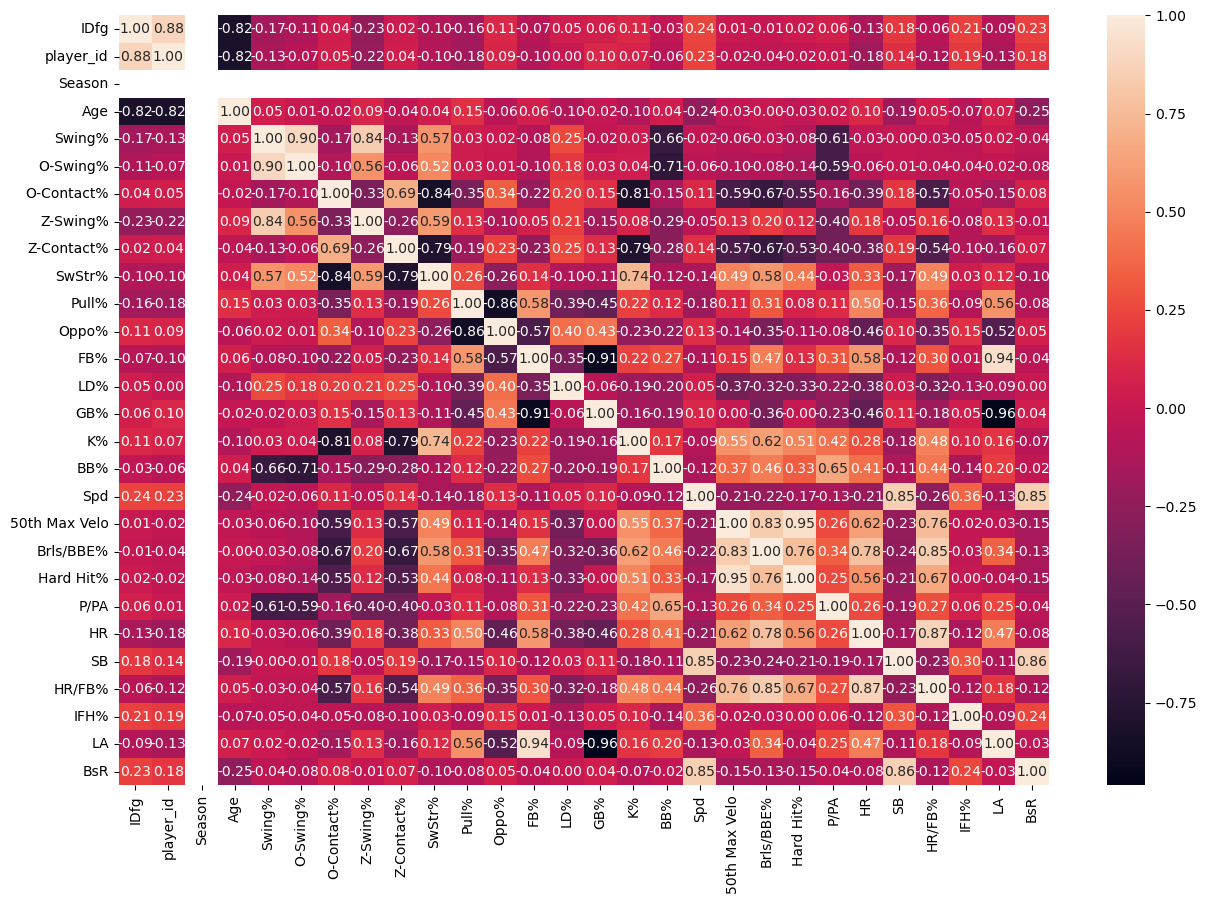

In [109]:
# Select only numeric columns
numeric_cols = merged_df.select_dtypes(include=[np.number])

plt.figure(figsize=(15, 10))
sns.heatmap(numeric_cols.corr(), annot=True, fmt=".2f")
plt.show()

# Scaling and Hopkins Statistic

Scaling your features is crucial for various clustering algorithms such as Fuzzy C-means, which utilizes distances to gauge the degree of membership for each data point within a cluster, and OPTICS, which relies on reachability distances to delineate clusters. Scaling helps prevent features with varying units from disproportionately influencing these distance metrics, which are highly sensitive to the scale of the data.

In [ ]:
# Scaling the numeric data features

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Create a list of columns to scale, excluding 'IDfg', 'player_id', and 'Season'
columns_to_scale = merged_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
columns_not_to_scale = ['IDfg', 'player_id', 'Season']
numeric_cols = [col for col in columns_to_scale if col not in columns_not_to_scale]

# Fit the scaler to the numeric columns
scaler.fit(merged_df[numeric_cols])

# Scale the numeric columns
merged_df[numeric_cols] = scaler.transform(merged_df[numeric_cols])

# Now 'merged_df_scaled' has scaled numeric columns

merged_df_scaled = merged_df[numeric_cols]

### The Hopkins statistic is used to assess how likely your data is to have meaningful clusters. It ranges from 0 to 1, with different ranges indicating the following:

- Close to 0.5: This suggests the data is randomly distributed, with no significant clusters.
- Between 0.7 and 0.99: This indicates a high tendency for the data to cluster. This is generally considered a good range for clustering.
- Close to 1: This is a strong indication that the data has well-defined clusters.

In [ ]:
from sklearn.neighbors import NearestNeighbors
import random
from random import sample

def hopkins_statistic(X):
    n = len(X) # number of rows in the DataFrame
    m = int(0.1 * n) # subset size, e.g., 10% of the total number of points
    nbrs = NearestNeighbors(n_neighbors=2).fit(X)
    rand_X = sample(range(0, n), m)
    
    u_dist = np.array([nbrs.kneighbors([X.iloc[i].to_numpy()], return_distance=True)[0][0][1] for i in rand_X])
    v_dist = np.array([np.linalg.norm(np.random.uniform(np.amin(X, axis=0), np.amax(X, axis=0)) - X.iloc[random.choice(rand_X)]) for _ in range(m)])
    
    H = sum(u_dist) / (sum(u_dist) + sum(v_dist))
    return H

# Select numerical columns for the analysis
X = merged_df_scaled

# Calculate the Hopkins statistic
H = hopkins_statistic(X)
print(f"Hopkins statistic: {H}")

# Dimensionality Reduction Techniques
Dimensionality reduction is a to reduce the number of dimensions (features) in a data set. The goal of dimensionality reduction is to decrease the data set's complexity by reducing the number of features while keeping the most important properties of the original data.

## Principal Component Analysis (PCA)

By performing PCA, you are transforming your data into a new set of features (principal components) that capture the maximum variance in the original data. 

These principal components are linear combinations of your original features, and they are uncorrelated with each other. One of the main differences between PCA and other dimensionality reduction techniques, like t-SNE or UMAP is that PCA focuses on linear relationships while those other two are concerned with non-linear relationships.

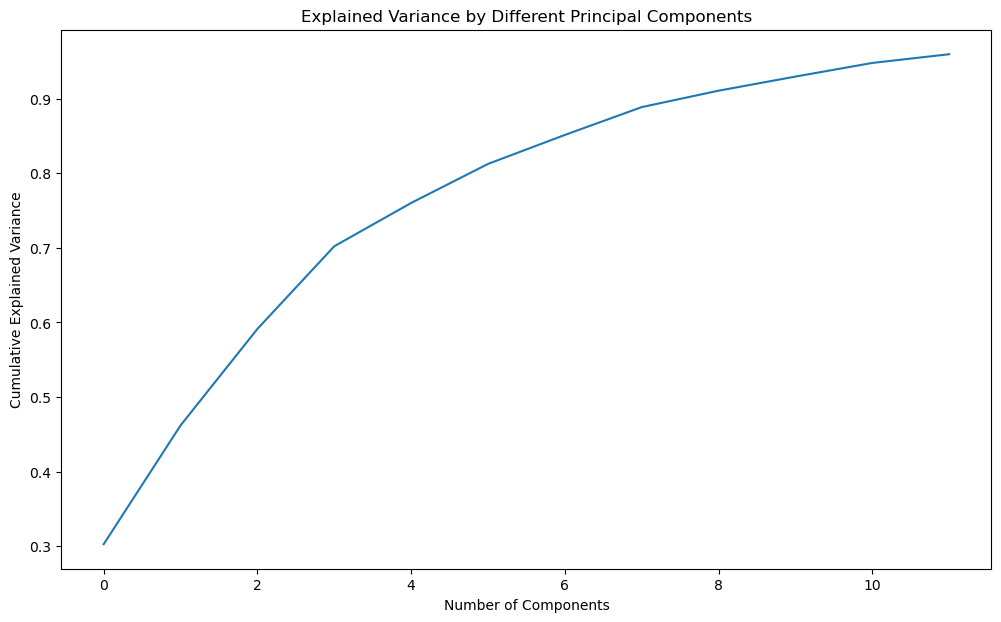

Explained Variance Ratio for Each Component:
Component 1: 30.26%
Component 2: 15.93%
Component 3: 12.94%
Component 4: 11.09%
Component 5: 5.81%
Component 6: 5.24%
Component 7: 3.88%
Component 8: 3.74%
Component 9: 2.20%
Component 10: 1.89%
Component 11: 1.83%
Component 12: 1.17%
Total Explained Variance Ratio: 95.97%


In [125]:
from sklearn.decomposition import PCA

# the number of components where 95% variance is retained
pca = PCA(n_components=0.95)
pca_result = pca.fit_transform(merged_df_scaled)

# Plot the explained variance ratio
plt.figure(figsize=(12, 7))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Different Principal Components')
plt.show()

pca = PCA(n_components=12)
pca_result = pca.fit_transform(merged_df_scaled)

# Explained variance ratio for each component (percentage)
explained_variance_ratio = pca.explained_variance_ratio_ * 100  # Multiply by 100 for percentage

print("Explained Variance Ratio for Each Component:")
for i, ratio in enumerate(explained_variance_ratio):
  print(f"Component {i+1}: {ratio:.2f}%")

total_variance = sum(pca.explained_variance_ratio_ * 100)
print(f"Total Explained Variance Ratio: {total_variance:.2f}%")

The goal for determining the number of principal components to retain in PCA is often based on capturing a certain percentage of the total variance in the dataset. A common target is to retain enough principal components to explain around 70% to 95% of the total variance.

The 12 components ploted above, captures 95.97% of the variance.

## T-distributed Stochastic Neighbor Embedding (t-SNE)

[t-SNE] Computing 110 nearest neighbors...
[t-SNE] Indexed 111 samples in 0.001s...
[t-SNE] Computed neighbors for 111 samples in 0.028s...
[t-SNE] Computed conditional probabilities for sample 111 / 111
[t-SNE] Mean sigma: 2.842201
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.652721
[t-SNE] KL divergence after 300 iterations: 0.521163


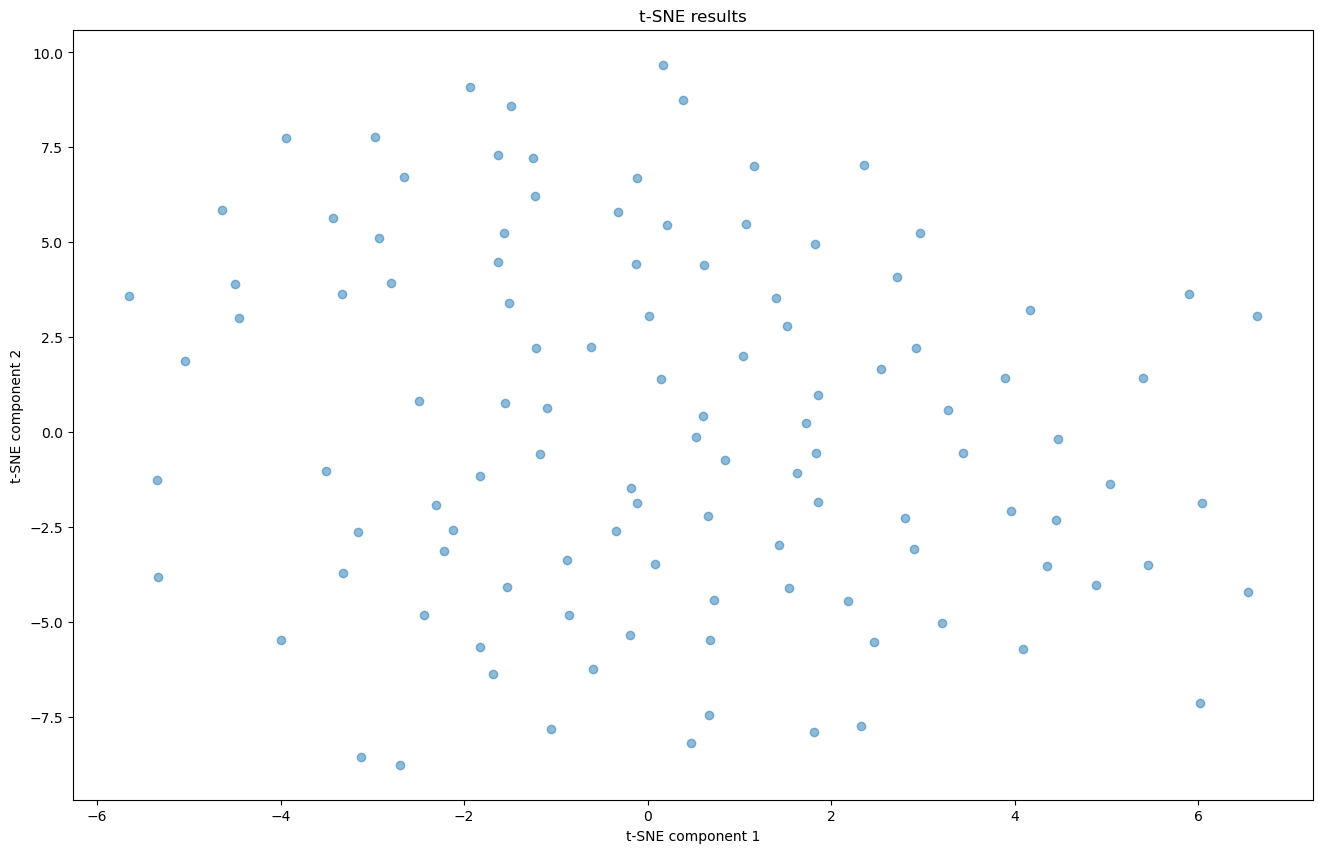

In [120]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X = merged_df_scaled.values

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

tsne_results = tsne.fit_transform(X)

plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:,0], tsne_results[:,1], alpha=0.5) # Adjust alpha for point transparency
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.title('t-SNE results')
plt.show()

Here's how to interpret the t-SNE plot:

**1. Cluster Patterns:** Look for clusters of points that are close to each other; these represent groups of hitters with similar profiles according to the data.

**2. Outliers:** Points that are far away from others could be considered outliers. They have a unique profile that sets them apart from the rest of the players.

**3. Density:** The density of points in certain areas can give you an idea of how common certain player profiles are. Sparse areas indicate less common profiles.

There appear to be some loose groupings, but there isn't a clear separation between clusters. So let's adjust the hyperparameters of t-SNE to see if there's a more consistent pattern that emerges.



[Here's a great read on the importance of  hyperparameters & how to use t-SNE in general.](https://distill.pub/2016/misread-tsne/)

[t-SNE] Computing 17 nearest neighbors...
[t-SNE] Indexed 111 samples in 0.000s...
[t-SNE] Computed neighbors for 111 samples in 0.032s...
[t-SNE] Computed conditional probabilities for sample 111 / 111
[t-SNE] Mean sigma: 1.491143
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.129417
[t-SNE] KL divergence after 4000 iterations: 0.876704


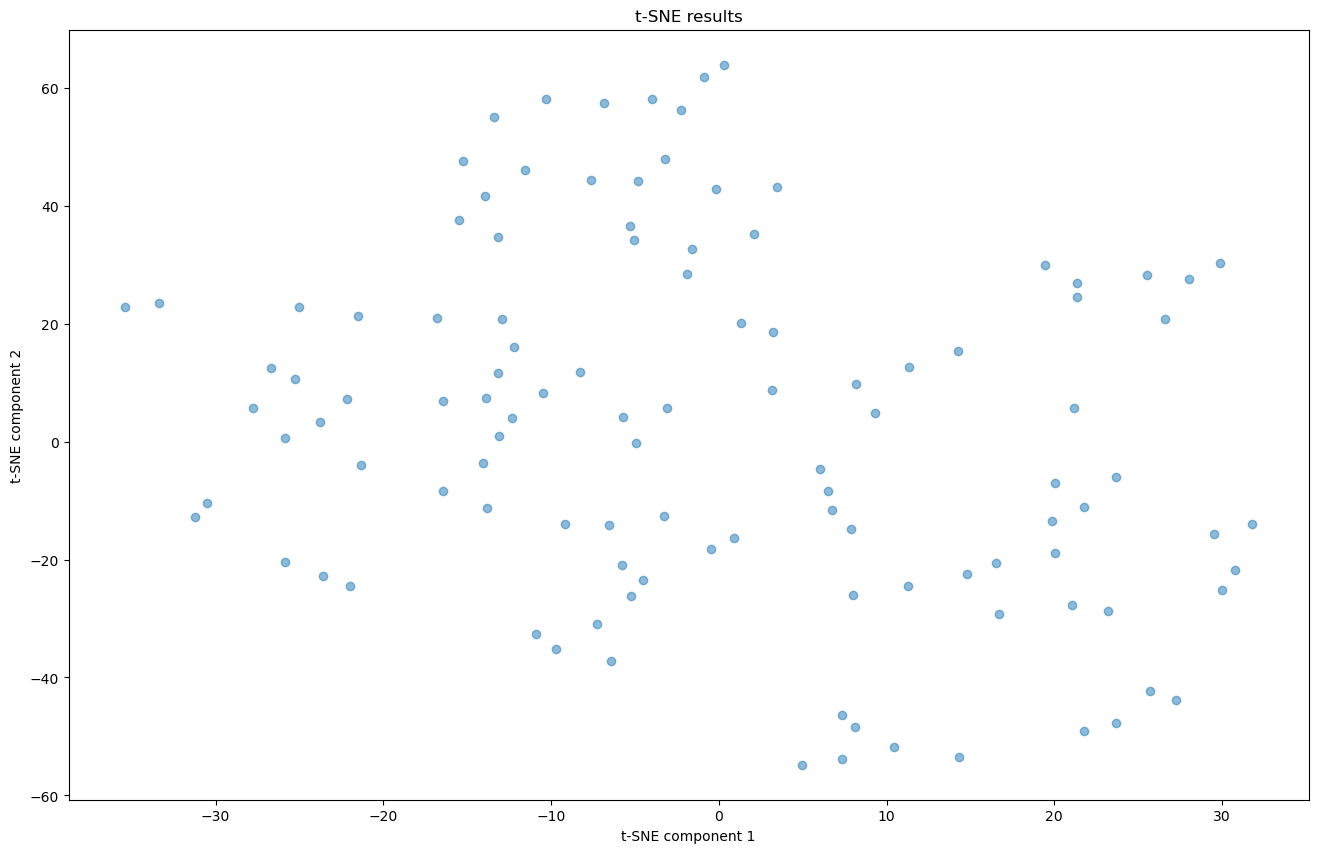

In [123]:
X = merged_df_scaled.values
 
tsne = TSNE(n_components=2, verbose=1, perplexity=5.55, n_iter=5000) # adjust perplexity & interations if needed

tsne_results = tsne.fit_transform(X)


plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:,0], tsne_results[:,1], alpha=0.5)
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.title('t-SNE results')
plt.show()

**Perplexity:**
Imagine each data point on a graph as a person.
Perplexity is like asking each person, "How many close friends do you have?"
A low perplexity means each person considers only a few very close friends.
A high perplexity means each person counts a lot of friends as close.


When t-SNE is working to arrange these data points on a graph:

A low perplexity tells t-SNE to focus more on arranging points based on their very closest relationships.


A high perplexity tells t-SNE to consider more distant relationships as well, spreading the points out more evenly.

Choosing the right perplexity is like deciding how far each person's social circle extends – it affects how the points are arranged on the graph and how they relate to each other.

With this t-SNE plot I adjusted the perplexity, from what I've read some people like setting the perplixty to 5% of the dataset. In this case, the dataset had 111 columns so I went with 5.55.

I also upped the iterations from 300 to 5000. More iterations allows the algorithm more opportunities to converge to a stable solution where the positions of the points in the lower-dimensional space accurately represent the relationships between them in the original high-dimensional space.

[t-SNE] Computing 17 nearest neighbors...
[t-SNE] Indexed 111 samples in 0.002s...
[t-SNE] Computed neighbors for 111 samples in 0.026s...
[t-SNE] Computed conditional probabilities for sample 111 / 111
[t-SNE] Mean sigma: 1.491143
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.663773
[t-SNE] KL divergence after 3850 iterations: 0.880365
[t-SNE] Computing 17 nearest neighbors...
[t-SNE] Indexed 111 samples in 0.000s...
[t-SNE] Computed neighbors for 111 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 111 / 111
[t-SNE] Mean sigma: 1.491143
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.129417
[t-SNE] KL divergence after 4000 iterations: 0.876704
[t-SNE] Computing 17 nearest neighbors...
[t-SNE] Indexed 111 samples in 0.001s...
[t-SNE] Computed neighbors for 111 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 111 / 111
[t-SNE] Mean sigma: 1.491143
[t-SNE] KL divergence after 250 iteratio

Text(0, 0.5, 't-SNE Component 2')

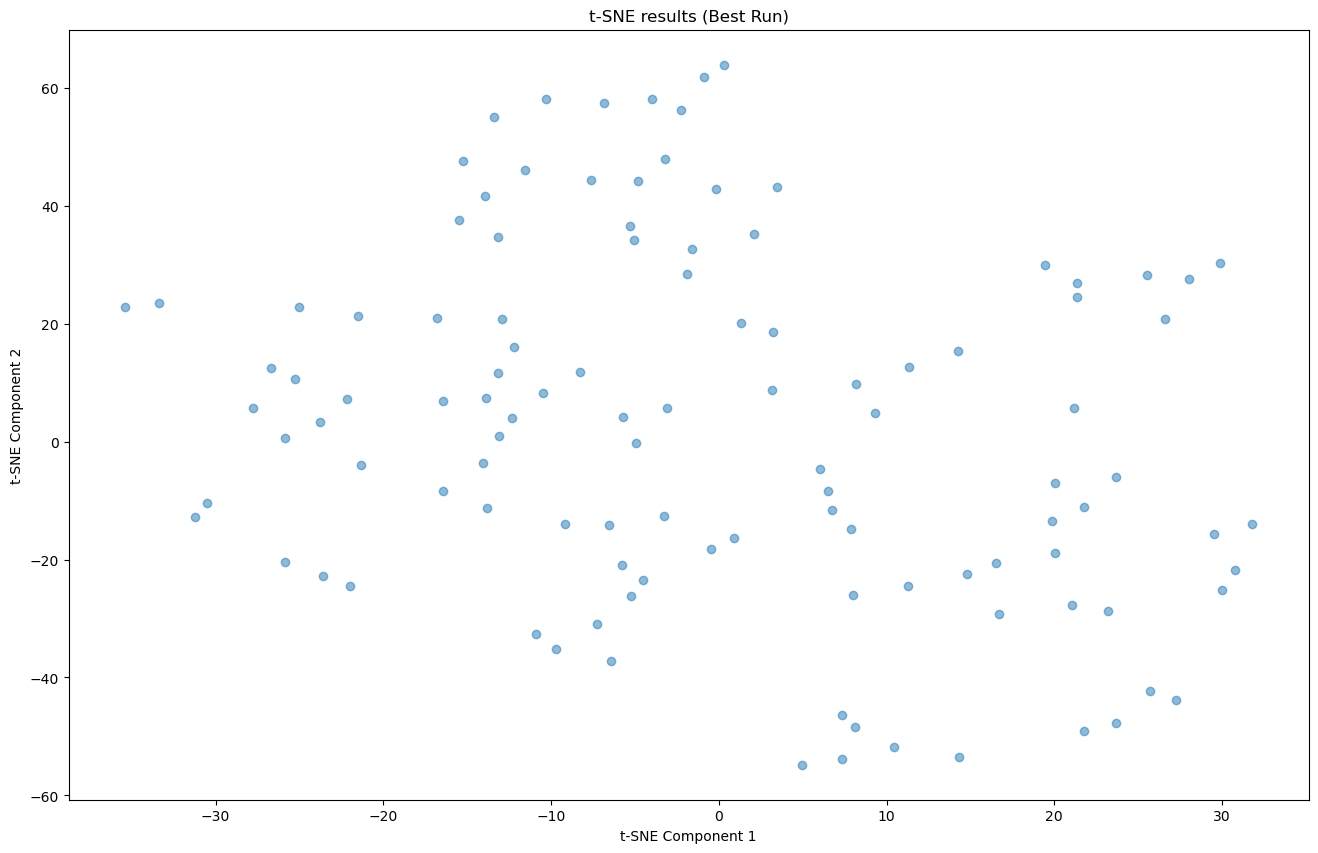

In [166]:
X = merged_df_scaled.values

perplexity = 5.55
iterations = 5000
n_runs = 3

# a list to store the KL divergence scores
kl_divergences = []

for i in range(n_runs):
    tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=iterations, random_state=i)
    tsne_results = tsne.fit_transform(X)
    kl_divergences.append(tsne.kl_divergence_)

# Find the index of the run with the lowest KL divergence
best_run_index = np.argmin(kl_divergences)
best_kl_divergence = kl_divergences[best_run_index]

print(f"Best Run Index: {best_run_index}")
print(f"Best KL Divergence: {best_kl_divergence}")

# The best model to get the corresponding t-SNE results
best_tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=iterations, random_state=best_run_index)
best_tsne_results = best_tsne.fit_transform(X)

plt.figure(figsize=(16, 10))
plt.scatter(best_tsne_results[:, 0], best_tsne_results[:, 1], alpha=0.5)
plt.title('t-SNE results (Best Run)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# III. Cluster Algorithims
## Fuzzy C-Means